# **CAPSTONE PROJECT STUDI INDEPENDEN - MBKM USK UNGGUL**

Nama             : T. Muhammad Caesar Maulana

NIM              : 2004111010001

Dosen Pembimbing : Dr. Khairun Saddami, ST

Arsitektur       : Vision Transformer

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install modul
!pip install split-folders
!pip install -U transformers datasets
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb

import wandb
wandb.login() #API: 59183b44f5541ddae464016a0b25fd9d7c298f96
%env WANDB_PROJECT=vit-banana-leaf-classify-model-v1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: caesar_maulana. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=vit-banana-leaf-classify-model-v1


In [ ]:
# Membagi folder menjadi set train dan val dengan pembagian 80–20 persen
!splitfolders --ratio .8 .2  -- /content/drive/MyDrive/Banana-Leaf-Dataset-Lite

Copying files: 554 files [00:02, 196.82 files/s]


In [ ]:
# Import modul
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
import torch
from datasets import load_dataset, load_metric
import numpy as np

# Deklarasi path dataset
DATASET_DIR = '/content/output'
dataset = load_dataset(name="banana-leaf-datasets", path=DATASET_DIR, data_files={"train": "/content/output/train/**", "test": "/content/output/val/**"})

# Label kelas dataset
labels = dataset['train'].features['label'].names

Resolving data files:   0%|          | 0/443 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

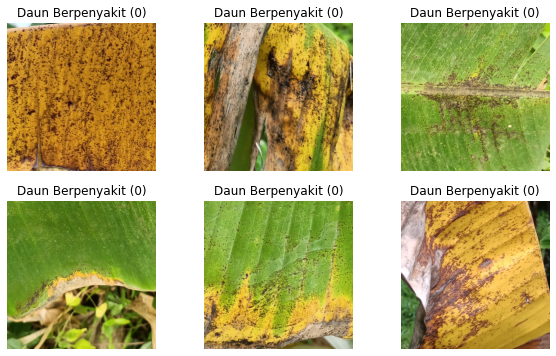

In [ ]:
import matplotlib.pyplot as plt
# plot samples
samples = dataset['train'].select(range(10))
pointer = 0
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1
plt.show()

In [ ]:
# Mengonversi Gambar PIL mentah yang dibaca oleh pustaka set data ke format tensor yang cocok untuk dimasukkan ke model
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [ ]:
# Mendefinisikan metrik untuk menghitung akurasi
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  import sys


In [ ]:
# Mendefinisikan model dan ekstraktor fitur dari pos pemeriksaan yang ditentukan oleh model_name_or_path
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS=20
# Mendefinisikan objek trainer dengan parameter untuk training
training_args = TrainingArguments(
  output_dir="./vit-banana-leaf-classify-model-v1",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  logging_strategy = "epoch",
  save_strategy='epoch',
  logging_dir='result/logs',
  logging_steps=10,
  num_train_epochs=EPOCHS,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  run_name='vit-banana-leaf-classify-model-v1',
  load_best_model_at_end=True)

ValueError: ignored

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [ ]:
# Melatih model dan menyimpan kedalam folder vit-banana-leaf-classify-model-v1
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
wandb.finish()

In [ ]:
# Display a project workspace
%wandb caesar_maulana/vit-banana-leaf-classify-model-v1

# Initialize wandb.run first
wandb.init()

# If cell outputs wandb.run, you'll see live graphs
wandb.run

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# get our transformed dataset
zero_loader = DataLoader(prepared_ds['test'], batch_size=16)
zero_pred = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# zero-shot prediction
for batch in tqdm(zero_loader):
    with torch.no_grad():
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]
zero_true = [labels[i] for i in dataset['test']['label']]
# plot confusion matrix
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()
# metrics
print(f'Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

In [ ]:
# Import modul dan mendefinisikan modul yang digunakan untuk testing model
from transformers import ViTFeatureExtractor, ViTForImageClassification
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

model_name_or_path = 'vit-banana-leaf-classify-model-v1'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(model_name_or_path)

In [ ]:
# Mengambil gambar dari internet
url = "https://content.peat-cloud.com/w400/leaf-blotch-of-banana-banana-1563887348.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img)

# Melakukan prediksi dengan model yang telah dilatih
inputs = feature_extractor(images=img, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# Mengambil gambar dari internet
url = "http://daunijo.com/images/bekas-gigitan-belalang-daun.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img)

# Melakukan prediksi dengan model yang telah dilatih
inputs = feature_extractor(images=img, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
path = fn
img = image.load_img(path, target_size=(1000,1000))

imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

# Melakukan prediksi dengan model yang telah dilatih
inputs = feature_extractor(images=img, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# Import modul
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

# input gambar untuk testing
uploaded = files.upload()
for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(1000,1000))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # Melakukan prediksi dengan model yang telah dilatih
  inputs = feature_extractor(images=img, return_tensors="pt")
  outputs = model(**inputs)

  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# Kompres folder model
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

if __name__ == '__main__':
    zipf = zipfile.ZipFile('vit-banana-leaf-classify-model-v1.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir('/content/vit-banana-leaf-classify-model-v1', zipf)
    zipf.close()